# Using Deep Learning to "find" Supersymmetry with Pytorch
## (find problem set at the end of this notebook)

This is a modified version of Notebook 13 from https://physics.bu.edu/~pankajm/MLnotebooks.html which was written for the review https://arxiv.org/abs/1803.08823 A high-bias, low-variance introduction to Machine Learning for physicists.

To use a GPU select a runtime with a GPU (change runtime in the runtime menu).

In [3]:
#the following code downloads the data set and places it on your google colab instance. you need to run it only once, then you can comment it out when you re-run the notebook.

In [4]:
#! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz

In [5]:
#! gzip -d SUSY.csv.gz

## Learning Goals
The goal of this notebook is to introduce the powerful PyTorch framework for building neural networks and use it to analyze the SUSY dataset. After this notebook, the reader should understand the mechanics of PyTorch and how to construct DNNs using this package. In addition, the reader is encouraged to explore the GPU backend available in Pytorch on this dataset.

## Overview
In this notebook, we use Deep Neural Networks to classify the supersymmetry dataset, first introduced by Baldi et al. in [Nature Communication (2015)](https://www.nature.com/articles/ncomms5308). The SUSY data set consists of 5,000,000 Monte-Carlo samples of supersymmetric and non-supersymmetric collisions with $18$ features. The signal process is the production of electrically-charged supersymmetric particles which decay to $W$ bosons and an electrically-neutral supersymmetric particle that is invisible to the detector.

The first $8$ features are "raw" kinematic features that can be directly measured from collisions. The final $10$ features are "hand constructed" features that have been chosen using physical knowledge and are known to be important in distinguishing supersymmetric and non-supersymmetric collision events. More specifically, they are given by the column names below.

In this notebook, we study this dataset using Pytorch.

In [7]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs

# fix seed
#seed=17
#np.random.seed(seed)
#torch.manual_seed(seed)

## Structure of the Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Modify the hyperparameters to optimize performance for the specific data set

Below, we sometimes combine some of these steps together for convenience.

Notice that we take a rather different approach, compared to the simpler MNIST Keras notebook. We first define a set of classes and functions and run the actual computation only in the very end.

### Step 1: Load and Process the SUSY Dataset

The supersymmetry dataset can be downloaded from the UCI Machine Learning repository on [https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz](https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz). The dataset is quite large. Download the dataset and unzip it in a directory.

Loading data in Pytroch is done by creating a user-defined a class, which we name `SUSY_Dataset`, and is a child of the `torch.utils.data.Dataset` class. This ensures that all necessary attributes required for the processing of the data during the training and test stages are easily inherited. The `__init__` method of our custom data class should contain the usual code for loading the data, which is problem-specific, and has been discussed for the SUSY data set in Notebook 5. More importantly, the user-defined data class must override the `__len__` and `__getitem__` methods of the parent `DataSet` class. The former returns the size of the data set, while the latter allows the user to access a particular data point from the set by specifying its index.

In [10]:
from torchvision import datasets # load data

class SUSY_Dataset(torch.utils.data.Dataset):
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only.
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi',
                'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2',
                'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi',
                'missing energy magnitude', 'missing energy phi']

        high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


        #Number of datapoints to work with
        df = pd.read_csv(root_dir+data_file, header=None,nrows=dataset_size,engine='python')
        df.columns=features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col!="SUSY"]]

        # set training and test data size
        train_size=int(0.8*dataset_size)
        self.train=train

        if self.train:
            X=X[:train_size]
            Y=Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X=X[train_size:]
            Y=Y[train_size:]
            print("Testing on {} examples".format(dataset_size-train_size))


        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data=(X.values.astype(np.float32),Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data=(X[high_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data=(X[low_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both low-level features only.")


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])

        if self.transform:
            sample=self.transform(sample)

        return sample

Last, we define a helper function `load_data()` that accepts as a required argument the set of parameters `args`, and returns two generators: `test_loader` and `train_loader` which readily return mini-batches.

In [12]:
def load_data(args):

    data_file='SUSY.csv'
    root_dir="" #os.path.expanduser('~')+'/ML_review/SUSY_data/'

    kwargs = {} # CUDA arguments, if enabled
    # load and noralise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=True,high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=False,high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader

### Step 2: Define the Neural Net and its Architecture

To construct neural networks with Pytorch, we make another class called `model` as a child of Pytorch's `nn.Module` class. The `model` class initializes the types of layers needed for the deep neural net in its `__init__` method, while the DNN is assembled in a function method called `forward`, which accepts an `autograd.Variable` object and returns the output layer. Using this convention Pytorch will automatically recognize the structure of the DNN, and the `autograd` module will pull the gradients forward and backward using backprop.

Our code below is constructed in such a way that one can choose whether to use the high-level and low-level features separately and altogether. This choice determines the size of the fully-connected input layer `fc1`. Therefore the `__init__` method accepts the optional argument `high_level_feats`.

In [14]:
import torch.nn as nn # construct NN

class model(nn.Module):
    def __init__(self,high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()

        # an affine operation: y = Wx + b
        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200) # all features
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200) # low-level only
        else:
            self.fc1 = nn.Linear(8, 200) # high-level only

        self.fc2 = nn.Linear(200, 100) # see forward function for dimensions
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        #optional dropout regularization
        #x = F.dropout(x, training=self.training)

        # apply rectified linear unit
        x = F.relu(self.fc2(x))
        #optional dropout regularization
        #x = F.dropout(x, training=self.training)

        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x,dim=1)

        return x

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model

Next, we define the function `evaluate_model`. The first argument, `args`, contains all hyperparameters needed for the DNN (see below). The second and third arguments are the `train_loader` and the `test_loader` objects, returned by the function `load_data()` we defined in Step 1 above. The `evaluate_model` function returns the final `test_loss` and `test_accuracy` of the model.

First, we initialize a `model` and call the object `DNN`. In order to define the loss function and the optimizer, we use modules `torch.nn.functional` (imported here as `F`) and `torch.optim`. As a loss function we choose the negative log-likelihood, and stored is under the variable `criterion`. As usual, we can choose any from a variety of different SGD-based optimizers, but we focus on the traditional SGD.

Next, we define two functions: `train()` and `test()`. They are called at the end of `evaluate_model` where we loop over the training epochs to train and test our model.

The `train` function accepts an integer called `epoch`, which is only used to print the training data. We first set the `DNN` in a train mode using the `train()` method inherited from `nn.Module`. Then we loop over the mini-batches in `train_loader`. We cast the data as pytorch `Variable`, re-set the `optimizer`, perform the forward step by calling the `DNN` model on the `data` and computing the `loss`. The backprop algorithm is then easily done using the `backward()` method of the loss function `criterion`. We use `optimizer.step` to update the weights of the `DNN`. Last print the performance for every minibatch. `train` returns the loss on the data.

The `test` function is similar to `train` but its purpose is to test the performance of a trained model. Once we set the `DNN` model in `eval()` mode, the following steps are similar to those in `train`. We then compute the `test_loss` and the number of `correct` predictions, print the results and return them.  

In [16]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

def evaluate_model(args,train_loader,test_loader):

    # create model
    DNN = model(high_level_feats=args.high_level_feats)
    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))


    ################################################

    def train(epoch):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        avg_loss_epoch = 0
        # loop over training data
        for batch_idx, (data, label) in enumerate(train_loader):
            # zero gradient buffers
            optimizer.zero_grad()
            # compute output of final layer: forward step
            output = DNN(data)
            # compute loss
            loss = criterion(output, label.long())
            # run backprop: backward step
            loss.backward()
            # update weigths of NN
            optimizer.step()

            # print loss at current epoch
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item() ))
            avg_loss_epoch += loss.item()

        return avg_loss_epoch/len(train_loader) #loss.item()

    ################################################

    def test():
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0 # loss function on test data
        correct = 0 # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            # compute model prediction softmax probability
            output = DNN(data)
            # compute test loss
            test_loss += criterion(output, label.long(), size_average=False).item() # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

        # print test loss
        test_loss /= len(test_loader.dataset) #this gives average loss per sample

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))


        return test_loss, correct / len(test_loader.dataset)


    ################################################


    train_loss=np.zeros((args.epochs,))
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)

    epochs=range(1, args.epochs + 1)
    for epoch in epochs:
        train_loss[epoch-1] = train(epoch)
        test_loss[epoch-1], test_accuracy[epoch-1] = test()


    return test_loss, test_accuracy, train_loss

### Step 6a: Run a single training

MM: i added some code here to the original notebook to run a single training, before we move on to the grid search over hyperparameters

In [19]:
def single_training(args):
  # load data
  train_loader, test_loader = load_data(args)

  test_loss,test_accuracy,train_loss = evaluate_model(args,train_loader,test_loader)
  return test_loss, test_accuracy, train_loss

In [20]:
def plot_loss_single_training(test_loss,test_accuracy,train_loss):

  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(train_loss,label='training loss')
  ax.plot(test_loss,label='test loss')
  plt.legend()
  fig.tight_layout()
  plt.show()

### Step 6: Modify the Hyperparameters to Optimize Performance of the Model

To study the performance of the model for a variety of different `data_set_sizes` and `learning_rates`, we do a grid search.

Let us define a function `grid_search`, which accepts the `args` variable containing all hyper-parameters needed for the problem. After choosing logarithmically-spaced `data_set_sizes` and `learning_rates`, we first loop over all `data_set_sizes`, update the `args` variable, and call the `load_data` function. We then loop once again over all `learning_rates`, update `args` and call `evaluate_model`.

In [22]:
def grid_search(args):

    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes=[1000, 10000, 100000, 200000] #np.logspace(2,5,4).astype('int')
    learning_rates=np.logspace(-5,-1,5)

    # pre-alocate data
    test_loss=np.zeros((len(dataset_sizes),len(learning_rates)),dtype=np.float64)
    test_accuracy=np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size=dataset_size
        args.batch_size=int(0.01*dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr=lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )

            test_l,test_acc,train_l = evaluate_model(args,train_loader,test_loader)
            #we need only the last value:
            test_loss[i,j]=test_l[-1]
            test_accuracy[i,j]=test_acc[-1]


    return learning_rates,dataset_sizes,test_accuracy

Last, we use the function `plot_data`, defined below, to plot the results.

In [24]:
import matplotlib.pyplot as plt

def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)

    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{dataset\\ size}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()

## Run Code

As we mentioned in the beginning of the notebook, all functions and classes discussed above only specify the procedure but do not actually perform any computations. This allows us to re-use them for different problems.

Actually running the training and testing for every point in the grid search is done below. The `argparse` class allows us to conveniently keep track of all hyperparameters, stored in the variable `args` which enters most of the functions we defined above.

To run the simulation, we call the function `grid_search`.

In [26]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

device = torch.device("cuda")

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')
parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                help='learning rate (default: 0.05)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                help='SGD momentum (default: 0.5)')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                help='how many batches to wait before logging training status')
args = parser.parse_args()

# set seed of random number generator
torch.manual_seed(args.seed)

print (args)

Namespace(dataset_size=100000, high_level_feats=None, batch_size=100, test_batch_size=1000, epochs=10, lr=0.05, momentum=0.8, seed=2, log_interval=10)


In [27]:
%%capture
#run a single training
args.epochs=20
test_loss,test_accuracy,train_loss = single_training(args)

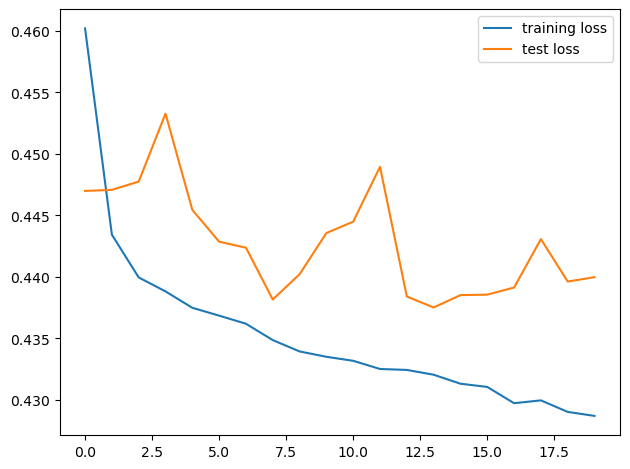

In [28]:
plot_loss_single_training(test_loss,test_accuracy,train_loss)

In [29]:
#for the parameters above, the network already overtrains at around 20 epochs. this can be changed by adding dropout regularization.

In [30]:
%%capture
#run a grid search over parameters
args.epochs=10
learning_rates,dataset_sizes,test_accuracy = grid_search(args)

C:\Users\odog2\AppData\Local\Temp\ipykernel_12516\266507982.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+x)
C:\Users\odog2\AppData\Local\Temp\ipykernel_12516\266507982.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+y)


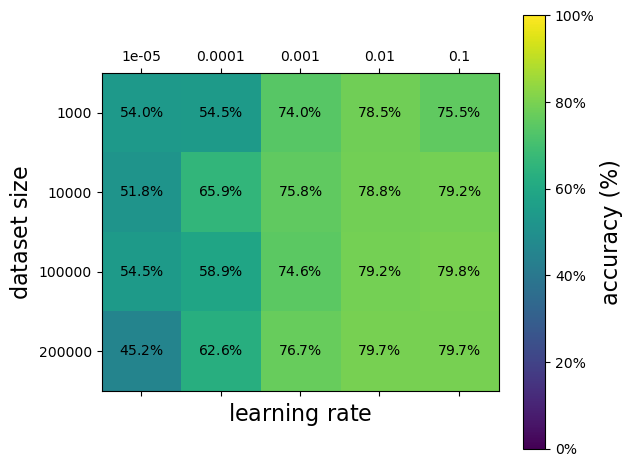

In [31]:
plot_data(learning_rates,dataset_sizes,test_accuracy)

In [32]:
#the best value is in the right bottom, so we may experiment with even larger networks and learning rates.
#in the original study (Baldi et al., 2014), the authors achieved ≈ 89% by using the entire dataset with 5, 000, 000 points and a more sophisticated network architecture

# Problem Set 2
The goal here is to understand how the code is working, how to modify simple things, and how they affect the results.
In the problems below, you are asked to produce numbers, code pieces and plots.

Please submit a solution as a notebook
 (feel free to modify this one, just make sure one can clearly find the beginning and the end of the answer to each question)

Note that neural network training results are slightly random (due to the random weight initialization) and so you may not get exactly the same numbers on different tries. We thus won’t require exact numerical results.

**1. Run default configuration**

Re-run the training script in your own colab instance. For the default configuration, which is the one specified below the line
parser = argparse.ArgumentParser(description='PyTorch SUSY Example'),
what is the accuracy of the classifier after training. What would be the value of the accuracy if the neural network would give a random answer?
Note that to run the notebook faster you may want to comment out the function grid_search(args) which we won’t need below.

**2. Regularization with Dropout**

Train the model with the function single_training(...) for 100 epochs. You will find over-training, which we discussed in lecture 5. Show the plot. One way to reduce overtraining is to add so-called dropout. Uncomment the two dropout lines in the code of the model and re-train. Make a plot of the new training and test loss and show it. Is there still over-training visible in the plot?

Make a plot that shows the test loss curve with and without dropout in the same plot. Research how dropout works. Write a few sentences explaining it.

**3. Do the human-made high-level features help or not?**
Read the introduction of the colab notebook about the hand constructed features. Run the training (with dropout, for 100 epoch) with all features, with only low-level features and with only high-level features. What is the accuracy in the 3 cases? Do the human-made features help? Why could they potentially help?


**4. What is the number of free parameters in your neural network (default configuration)?**

Calculate the answer by hand (briefly explain your reasoning). Then check if you get the right number by letting torch count the parameters. It is helpful to define the following function for that:

```python
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
```

**5. Add another hidden layer and increase the training data set**

Let’s try to improve the quality (still use dropout and 100 epochs). First, let’s use 1mio training examples. What accuracy do you get?
Now let’s also increase the network capacity. Add another linear+relu+dropout block. It should have input dimension 100 and output dimension 100. Place it in the model code at the right spot so that the dimensions work with those of the other layers. Show your for the new model.
Still using 1mio samples, what accuracy do you get now? If you run into colab computation time limits you can reduce the training epochs.

**6. How good can you make it? (optional)**

Play around a bit to see how good you can make it. For example, try training longer or increasing the hidden (internal) dimensions of the MLP layers. You may be limited by the amount of computation time that google colab gives you for free. If you make progress let us know your accuracy and how you did it.


---
# Answers - Owen Erker

---
## 1. Run default configuration

The accuracy after training hovers around 79.0% - 81.0%.  
Due to this being a SUSY binary classification, we would expect the random accuracy to be around 50%.

In [36]:
%%capture
args.epochs=20
test_loss,test_accuracy,train_loss = single_training(args)

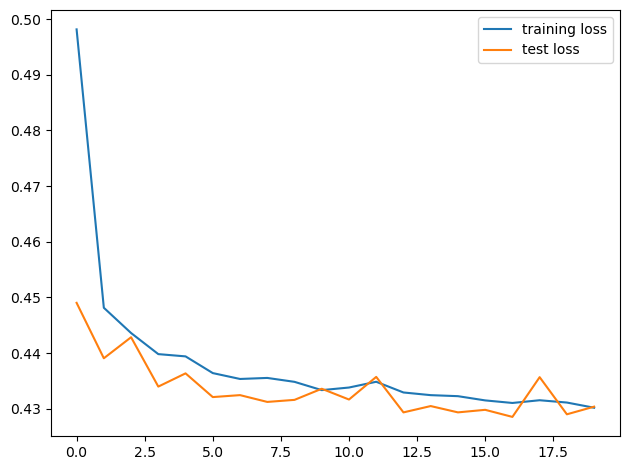

In [37]:
plot_loss_single_training(test_loss,test_accuracy,train_loss)

---
## 2. Regularization with Dropout

In [39]:
%%capture
args.epochs=100
test_loss_ndo, test_accuracy_ndo, train_loss_ndo = single_training(args)

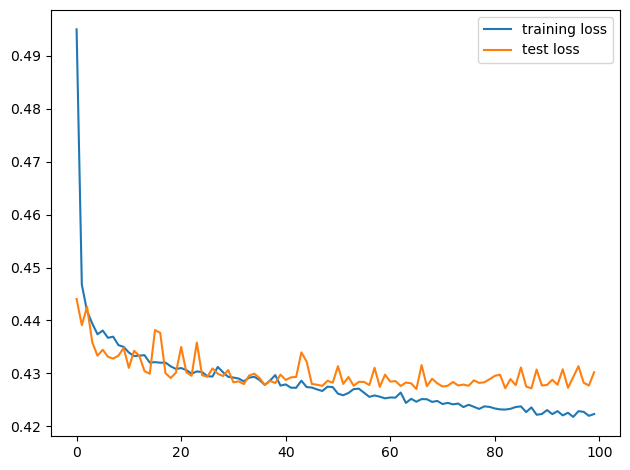

In [40]:
plot_loss_single_training(test_loss_ndo,test_accuracy_ndo,train_loss_ndo)

In [64]:
# Redefining model to include dropout and dropout plot function, as well as parameter count.
class model(nn.Module):
    def __init__(self,high_level_feats=None):
        super(model, self).__init__()

        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200)
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200)
        else:
            self.fc1 = nn.Linear(8, 200)

        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) # Reintroduced.

        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training) # Reintroduced.

        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)

        return x


# Dropout plot comparison.
def plot_loss_dropout(train_loss_do,train_loss_ndo):

  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(train_loss_ndo,label='training loss')
  ax.plot(train_loss_do,label='training loss (dropout)')
  plt.legend()
  fig.tight_layout()
  plt.show()

In [42]:
%%capture
args.epochs=100
test_loss_do, test_accuracy_do, train_loss_do = single_training(args)

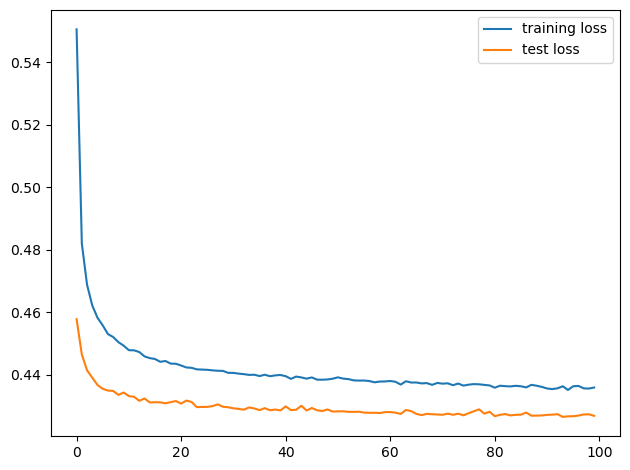

In [43]:
plot_loss_single_training(test_loss_do,test_accuracy_do,train_loss_do)

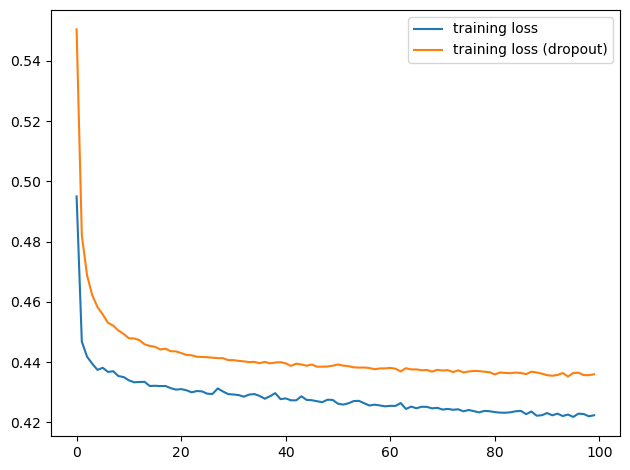

In [44]:
plot_loss_dropout(train_loss_do,train_loss_ndo)

There is still overtraining visible, but this is likely due to the number of "epochs" set to run. Running the `grid_search` function would likely help find the optimal number of epochs to train with.  
Dropout is a regularization technique used during training to prevent overfitting a model.  It randomly "drops" data during each iteration of training to ensure the training method does not heavily rely on any singular point of data during training.

---
## 3. Do the human-made high-level features help or not?

In [47]:
%%capture
args.epochs=100
test_loss_all, test_accuracy_all, train_loss_all = single_training(args)

args.epochs=100
args.high_level_features=False
test_loss_low, test_accuracy_low, train_loss_low = single_training(args)

args.epochs=100
args.high_level_features=True
test_loss_high, test_accuracy_high, train_loss_high = single_training(args)

In [80]:
print(f'All Feature Mean: {sum(test_accuracy_all)/len(test_accuracy_all)}\nLow Feature Mean: {sum(test_accuracy_low)/len(test_accuracy_low)}\nHigh Feature Mean: {sum(test_accuracy_high)/len(test_accuracy_high)}')

All Feature Mean: 0.8011069999999998
Low Feature Mean: 0.8013922499999998
High Feature Mean: 0.8012372499999999


In this instance, it is not obvious that the high-level features made a significant difference.  
In some cases, high-level features can lead to unrealized relationships between data and outcomes not previously obvious simply by looking at the raw data.  This can greatly improve the accuracy of a model.

---
## 4. What is the number of free parameters in your neural network (default configuration)?

Given these code block sections:  

```python
self.fc1 = nn.Linear(18, 200)  # Hidden Layer 1

self.fc2 = nn.Linear(200, 100) # Hidden Layer 2

self.fc3 = nn.Linear(100, 2)   # Hidden Layer 3
```
I believe there are $[(18\cdot 200)+200] + [(200\cdot 100)+100]  + [(100\cdot 2)+2] = 24,102$ parameters.

In [54]:
# Redefining model to exclude dropoutand include parameter count.
class model(nn.Module):
    def __init__(self,high_level_feats=None):
        super(model, self).__init__()

        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200)
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200)
        else:
            self.fc1 = nn.Linear(8, 200)

        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training) # Removed.

        x = F.relu(self.fc2(x))
        #x = F.dropout(x, training=self.training) # Removed.

        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)

        return x

# Parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [58]:
args.epochs=100
args.high_level_feats=None
DNN = model(args)
total_params = count_parameters(DNN)
print(f'Total Trainable Parameters: {total_params}')

Total Trainable Parameters: 22502


---

## 5. Add another hidden layer and increase the training data set

In [74]:
# Redefining model to include a fourth hidden layer and reintroduced dropout.
class model(nn.Module):
    def __init__(self,high_level_feats=None):
        super(model, self).__init__()

        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200)
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200)
        else:
            self.fc1 = nn.Linear(8, 200)

        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 100) # New Hidden Layer
        self.fc4 = nn.Linear(100, 2) # Renamed fc3 -> fc4

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) # Reintroduced

        x = F.relu(self.fc2(x)) 
        x = F.dropout(x, training=self.training) # Reintroduced

        x = F.relu(self.fc3(x)) # New Hidden Layer
        x = F.dropout(x, training=self.training) # Added dropout to new hidden layer.
        
        x = self.fc4(x) # Renamed fc3 -> fc4
        x = F.log_softmax(x,dim=1)

        return x

# Parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [76]:
%%capture
args.epochs=100
args.high_level_feats=None
test_loss, test_accuracy, train_loss = single_training(args)

Test Accuracy = 
[0.778725 0.7919   0.795825 0.79715  0.797525 0.79875  0.798475 0.7996
 0.79885  0.798975 0.79935  0.799175 0.7998   0.799325 0.80005  0.800425
 0.80065  0.800275 0.800025 0.800925 0.800975 0.800725 0.8012   0.799975
 0.8007   0.8014   0.800825 0.80105  0.801025 0.801375 0.8018   0.800675
 0.80205  0.8016   0.8017   0.8021   0.8015   0.801625 0.802375 0.80225
 0.801775 0.8024   0.80275  0.80235  0.802025 0.8021   0.80095  0.80135
 0.802475 0.801825 0.80215  0.8011   0.802225 0.8018   0.802225 0.8028
 0.80205  0.801575 0.801875 0.80175  0.80265  0.8026   0.802275 0.80235
 0.8012   0.802475 0.8024   0.80225  0.80255  0.801825 0.8028   0.802775
 0.80285  0.80295  0.8023   0.80235  0.80285  0.8029   0.802975 0.80245
 0.802225 0.802075 0.8032   0.803575 0.80225  0.802175 0.80275  0.802875
 0.80265  0.803275 0.8029   0.802175 0.802725 0.802525 0.803125 0.8026
 0.8025   0.802975 0.802475 0.80295 ]

 Mean Accuracy = 0.8012602499999999



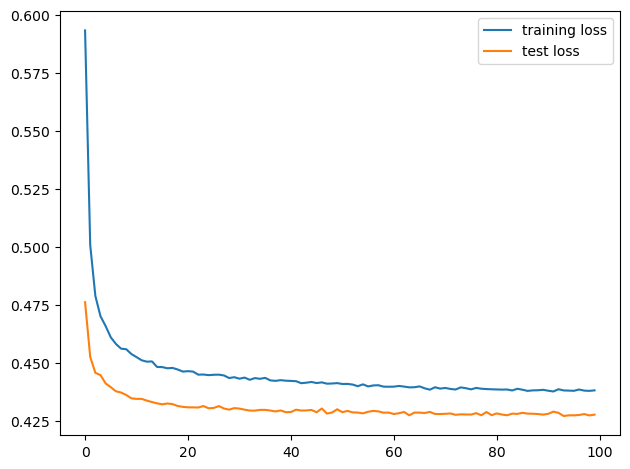

In [84]:
print(f'Test Accuracy = \n{test_accuracy}\n\n Mean Accuracy = {sum(test_accuracy)/len(test_accuracy)}\n')
plot_loss_single_training(test_loss,test_accuracy,train_loss)

The new test accuracy does not appear to have made any significant difference.

---